# Sampler Diagnostics Demo (Normal Crossing)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/timaeus-research/devinterp/blob/main/examples/diagnostics.ipynb)

Note: GradientNorm and NoiseNorm are currently incorrectly implemented, see [this issue](https://github.com/timaeus-research/devinterp/issues/90).


This notebook demonstrates the usage of various diagnostic tools for the sampling and RLCT estimation process. As an example, we'll use normal crossings for each diagnostic. This is a polynomial model characterized by $f(x) = w_1^a w_2^b x$ for some $(a, b)$, where $w_1$ and $w_2$ are weights to be learned. The data is generated with gaussian noise around the origin, so the model achieves its lowest loss when $w_1=0$ or $w_2 =0$.

We'll also be using the SGLD optimizer.

In [1]:
%pip install --upgrade pip
%pip install torch matplotlib seaborn devinterp

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from devinterp.optim.sgld import SGLD
from devinterp.utils import plot_trace, default_nbeta, get_init_loss_multi_batch
from devinterp.slt.sampler import sample, OnlineLLCEstimator, LLCEstimator

import warnings


warnings.filterwarnings("ignore")

In [3]:
from devinterp.utils import evaluate_mse

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# plotting
sns.set_style("whitegrid")
CMAP = sns.color_palette("muted", as_cmap=True)
PRIMARY, SECONDARY, TERTIARY = CMAP[:3]
plt.rcParams["figure.figsize"] = (
    12,
    9,
)  # note: this cell may need to be re-run after creating a plot to take effect

# constants
SIGMA = 0.25
NUM_TRAIN_SAMPLES = 1000
BATCH_SIZE = NUM_TRAIN_SAMPLES
LR = 0.0005

NUM_CHAINS = 20
NUM_DRAWS = 2000

In [4]:
# Set up RLCT estimation
class PolyModel(nn.Module):
    def __init__(self, powers):
        super(PolyModel, self).__init__()
        self.weights = nn.Parameter(
            torch.tensor(
                [1.0, 0.3], dtype=torch.float32, requires_grad=True, device=DEVICE
            )
        )
        self.powers = powers

    def forward(self, x):
        multiplied = torch.prod(self.weights**self.powers)
        x = x * multiplied
        return x


def generate_dataset_for_seed(seed=0):
    x = torch.normal(0, 2, size=(NUM_TRAIN_SAMPLES,))
    y = torch.normal(0, SIGMA, size=(NUM_TRAIN_SAMPLES,))
    train_data = TensorDataset(x, y)
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    return train_loader, train_data


def run_callbacks(
    train_loader,
    train_data,
    model,
    callbacks=None,
    device=DEVICE,
):
    nbeta = default_nbeta(train_loader)
    optim_kwargs = {
        "lr": 0.0005,
        "localization": 1.0,
        "save_noise": True,
        "nbeta": nbeta,
    }
    if callbacks is None:
        init_loss = get_init_loss_multi_batch(
            dataloader=train_loader,
            model=model,
            device=DEVICE,
            n_batches=16,
            evaluate=evaluate_mse,
        )
        llc_estimator = LLCEstimator(
            num_chains=NUM_CHAINS,
            num_draws=NUM_DRAWS,
            nbeta=nbeta,
            device=DEVICE,
            init_loss=init_loss,
        )
        callbacks = [llc_estimator]

    sample(
        model=model,
        loader=train_loader,
        evaluate=evaluate_mse,
        optimizer_kwargs=optim_kwargs,
        sampling_method=SGLD,
        num_chains=NUM_CHAINS,
        num_draws=NUM_DRAWS,
        callbacks=callbacks,
        device=device,
    )

    results = {}

    for callback in callbacks:
        if hasattr(callback, "get_results"):
            results.update(callback.get_results())

    return results


def get_rlct(
    train_loader,
    train_data,
    weights=[0.0, 0.0],
    lr=LR,
    powers=torch.tensor([1, 2]).to(DEVICE),
    device=DEVICE,
):
    model = PolyModel(powers).to(DEVICE)
    model.weights = nn.Parameter(
        torch.tensor(weights, dtype=torch.float32, requires_grad=True, device=DEVICE)
    )
    return run_callbacks(
        train_loader=train_loader,
        train_data=train_data,
        model=model,
        device=device,
    )["llc/mean"]

## Testing RLCT estimation

Let's start with estimating some RLCTs at known values for a simple normal crossing with $(a, b) = (1, 2)$.

In [5]:
train_loader, train_data = generate_dataset_for_seed(seed=0)

In [6]:
sample_points = [[0.0, 0.0], [1.0, 0.0], [0.0, 1.0], [0.1, 0.1]]
known_rlcts = [0.25, 0.25, 0.5, 0.25]
estimated_rlcts = [
    get_rlct(train_loader, train_data, weights=sample_point)
    for sample_point in sample_points
]

If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


Chain 0:   0%|          | 0/2000 [00:00<?, ?it/s]

Chain 19: 100%|██████████| 2000/2000 [00:01<00:00, 1012.15it/s]


If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


Chain 19: 100%|██████████| 2000/2000 [00:01<00:00, 1002.67it/s]


If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


Chain 19: 100%|██████████| 2000/2000 [00:02<00:00, 985.21it/s] 


If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


Chain 19: 100%|██████████| 2000/2000 [00:01<00:00, 1006.99it/s]


In [7]:
print(estimated_rlcts)

[0.20215097069740295, 0.22439537942409515, 0.3506951928138733, 0.2736113667488098]


## SamplerCallbacks

RLCT estimation uses a `SamplerCallback` class. A list of `SamplerCallback`s can be passed to `sample`, which causes each callback to be called at each draw made by the sampler for each chain. RLCT estimation passes a single `SamplerCallback`, `LLCEstimator` or `OnlineLLCEstimator` to `sample`.

Another such `SamplerCallback` is the `OnlineWBICEstimator`.

In [8]:
from devinterp.slt.wbic import OnlineWBICEstimator

wbic_estimator = OnlineWBICEstimator(
    num_chains=NUM_CHAINS, num_draws=NUM_DRAWS, n=NUM_TRAIN_SAMPLES, device=DEVICE
)

train_loader, train_data = generate_dataset_for_seed(seed=0)

nbeta = default_nbeta(train_loader)
weights = [0.0, 0.0]
powers = torch.tensor([1, 2]).to(DEVICE)
model = PolyModel(powers).to(DEVICE)
model.weights = nn.Parameter(
    torch.tensor(weights, dtype=torch.float32, requires_grad=True, device=DEVICE)
)

results = run_callbacks(
    train_loader, train_data, model=model, callbacks=[wbic_estimator]
)

If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


Chain 0:   0%|          | 0/2000 [00:00<?, ?it/s]

Chain 19: 100%|██████████| 2000/2000 [00:02<00:00, 950.93it/s]


In [9]:
# final WBIC estimate
results["wbic/means"][-1]

60.686073

The trace of a sampled statistic is an array of shape `[NUM_CHAINS, NUM_DRAWS]`, where the `[i, j]` entry is the value computed by the `SamplerCallback` at the *j*th draw of the *i*th chain.

It can sometimes be useful to plot the trace as a sanity check and to see where things might be going wrong. In the following graph, the estimated WBIC values level off and appear to converge, which is what we'd expect to see.

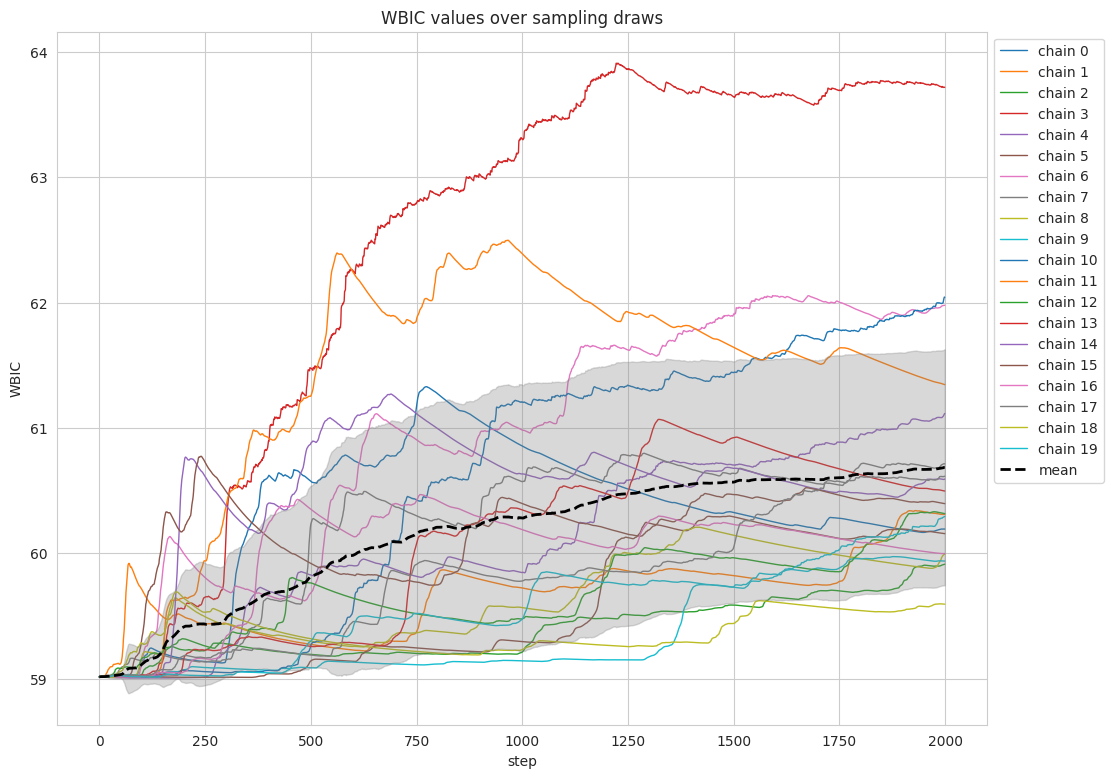

<Figure size 1200x900 with 0 Axes>

In [10]:
wbic_trace = results["wbic/trace"]
plot_trace(wbic_trace, "WBIC")

## Other diagnostics

There are various diagnostic tools implemented as `SamplerCallback`s. Some are regular `SamplerCallback`s that can be passed to `sample` on their own, and others are "derivative" callbacks that run diagnostics on a particular `SamplerCallback` instance.

Regular implementations:
- `OnlineWBICEstimator`: estimates WBIC (seen above)
- `MalaAcceptanceRate`: track the MALA acceptance 'probability' of the SGLD step. (Note: this does not change the SGLD algorithm, it only calculates a hypothetical acceptance rate.)
- `WeightNorm`: track the L2 norm of model weights during sampling
- `GradientNorm`: track the L2 norm of gradients during sampling
- `NoiseNorm`: track the L2 norm of SGLD noise term during sampling
- `GradientDistribution`: view a histogram/heatmap of gradient values at each SGLD step for specific named model parameters -- useful e.g. for checking that gradients haven't exploded or collapsed

Derivative implementations:
- `OnlineTraceStatistics`: compute the mean/std of the trace of another `SamplerCallback` across draws and across chains
- `OnlineLossStatistics`: computes various loss statistics for `OnlineLLCEstimator`

Additionally, since derivative callbacks depend on a base callback, they must be positioned later in the list of callbacks so that they're called after the base callback. A helper function `validate_callbacks` checks whether a list of callbacks satisfies this condition.

### MalaAcceptanceRate example

In [11]:
from devinterp.slt.mala import MalaAcceptanceRate

train_loader, train_data = generate_dataset_for_seed(seed=0)

mala_accept_rate = mala_estimator = MalaAcceptanceRate(
    num_chains=NUM_CHAINS,
    num_draws=NUM_DRAWS,
    nbeta=default_nbeta(train_loader),
    learning_rate=LR,
    device=DEVICE,
)


callbacks = [mala_accept_rate]

nbeta = default_nbeta(train_loader)
results = run_callbacks(train_loader, train_data, model=model, callbacks=callbacks)

If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


Chain 0:   9%|▉         | 185/2000 [00:00<00:02, 614.93it/s]

Chain 19: 100%|██████████| 2000/2000 [00:03<00:00, 641.58it/s]


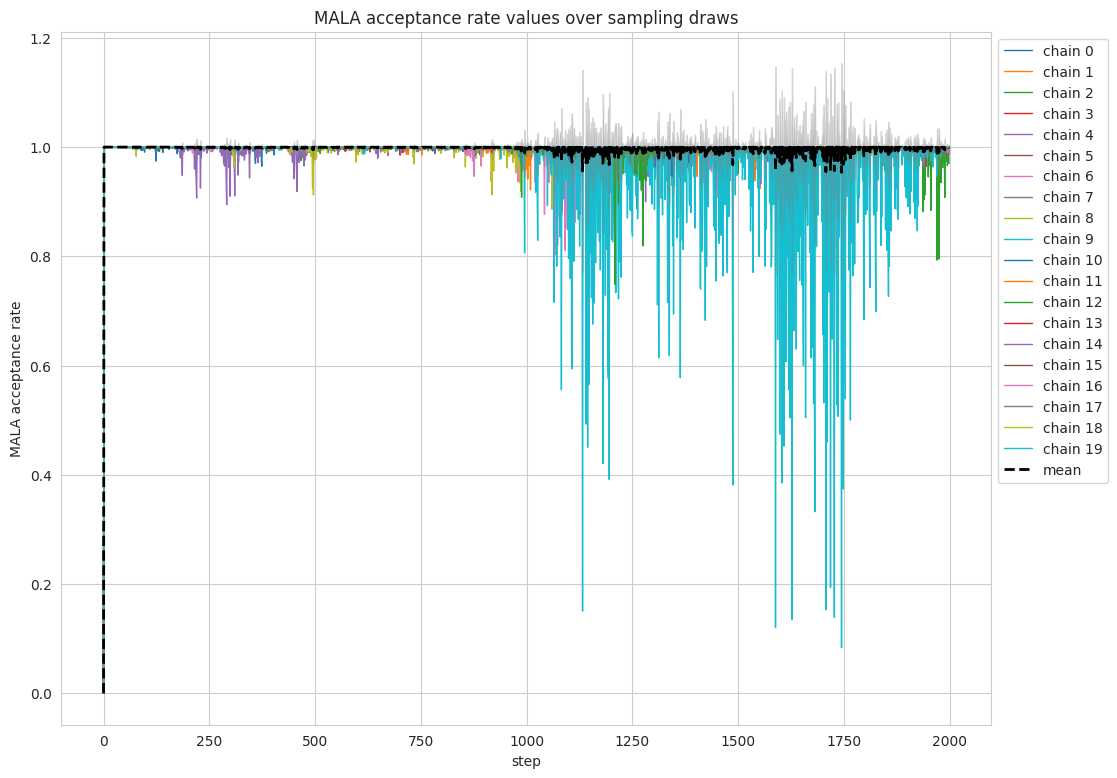

<Figure size 1200x900 with 0 Axes>

Average MALA acceptance rate over draws and chains is 0.9970715641975403


In [12]:
from numpy import mean

mala_trace = results["mala_accept/trace"]

plot_trace(mala_trace, "MALA acceptance rate")
print(f"Average MALA acceptance rate over draws and chains is {mean(mala_trace)}")

From this mean and plot, we should conclude that our acceptance rate could be a bit lower. Ideally we'd aim for $\sim0.9$, but this is not always achievable.

### WeightNorm, GradientNorm, NoiseNorm examples

In [13]:
from devinterp.slt.norms import GradientNorm, NoiseNorm, WeightNorm

gradient_norm = GradientNorm(num_chains=NUM_CHAINS, num_draws=NUM_DRAWS, device=DEVICE)
noise_norm = NoiseNorm(num_chains=NUM_CHAINS, num_draws=NUM_DRAWS, device=DEVICE)
weight_norm = WeightNorm(num_chains=NUM_CHAINS, num_draws=NUM_DRAWS, device=DEVICE)

norm_callbacks = [gradient_norm, noise_norm, weight_norm]

train_loader, train_data = generate_dataset_for_seed(seed=0)

results = run_callbacks(
    train_loader,
    train_data,
    model=model,
    callbacks=norm_callbacks,
)

If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


Chain 0:   0%|          | 0/2000 [00:00<?, ?it/s]

Chain 19: 100%|██████████| 2000/2000 [00:03<00:00, 643.84it/s]


The norms are stored as traces that we can plot below. It may be useful to, for example, compare the gradient norm and noise norm to ensure one isn't completely dominating the other. The weight trace can also be helpful to check whether the sampler appears to be spreading out in the weight space.

In [14]:
grad_trace = results["gradient_norm/trace"]
noise_trace = results["noise_norm/trace"]
weight_trace = results["weight_norm/trace"]

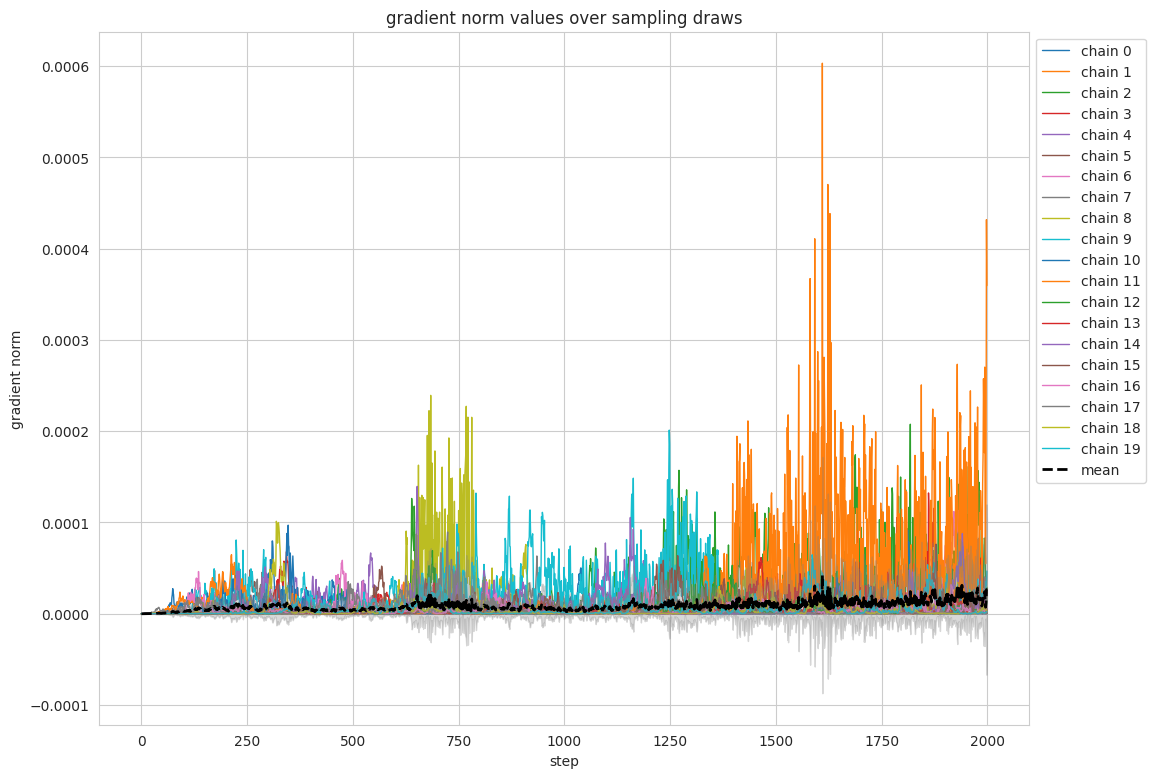

<Figure size 1200x900 with 0 Axes>

In [15]:
plot_trace(grad_trace, "gradient norm")

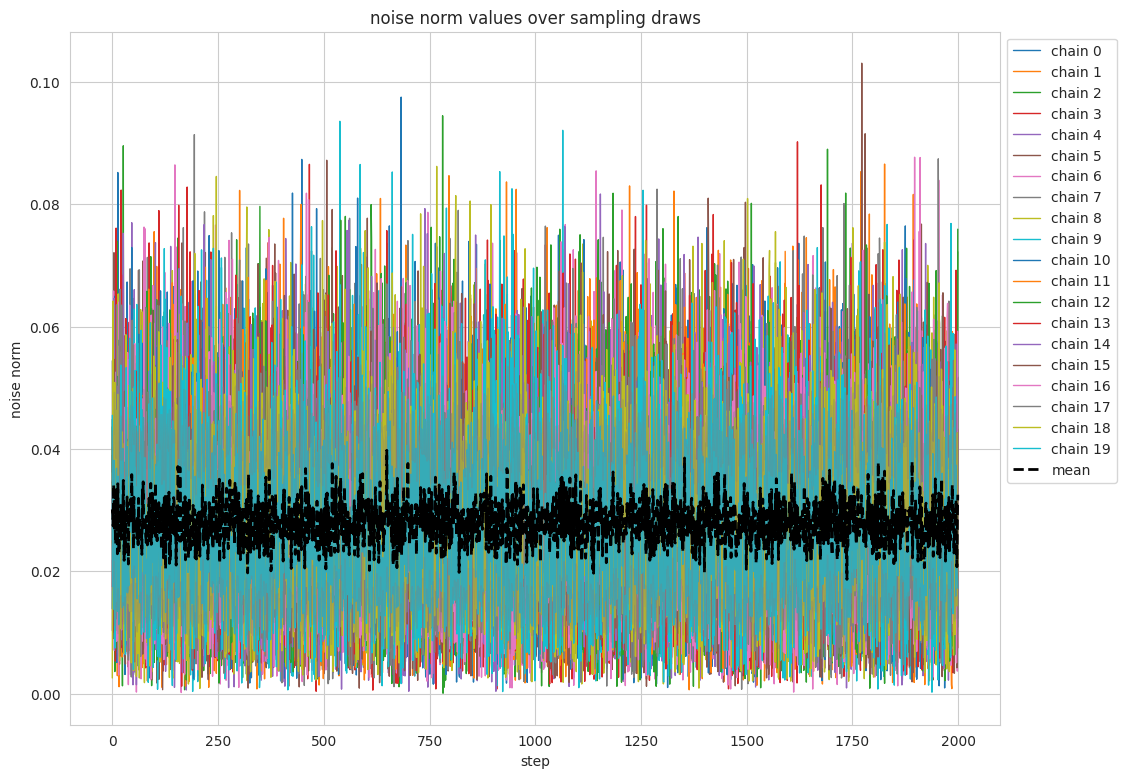

<Figure size 1200x900 with 0 Axes>

In [16]:
plot_trace(noise_trace, "noise norm")

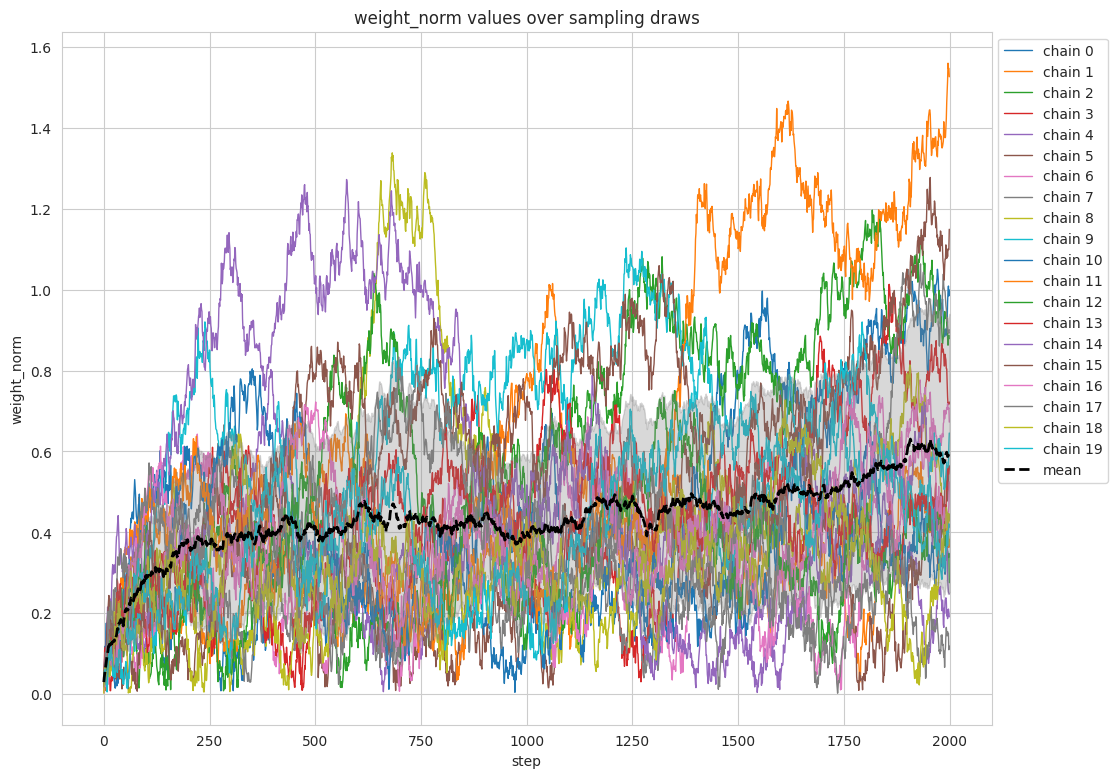

<Figure size 1200x900 with 0 Axes>

In [17]:
# note: the weight norm starts near 0 in this graph because the weights are initialized to [0, 0]
plot_trace(weight_trace, "weight_norm")

### GradientDistribution

`GradientDistribution` shows the histogram of gradient values at each SGLD time step, with a darker color indicating a bin with a higher count. Below, we can see that some gradient values are relatively large, but most cluster around 0 (the darker blue line). In this case, gradients don't seem to be exploding or collapsing during sampling.

In [18]:
from devinterp.slt.gradient import GradientDistribution

grad_dist = GradientDistribution(
    num_chains=NUM_CHAINS, num_draws=NUM_DRAWS, min_bins=40, device=DEVICE
)
callbacks = [grad_dist]
results = run_callbacks(train_loader, train_data, model=model, callbacks=callbacks)

If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


Chain 0:   2%|▏         | 48/2000 [00:00<00:04, 475.08it/s]

Chain 19: 100%|██████████| 2000/2000 [00:02<00:00, 726.89it/s]


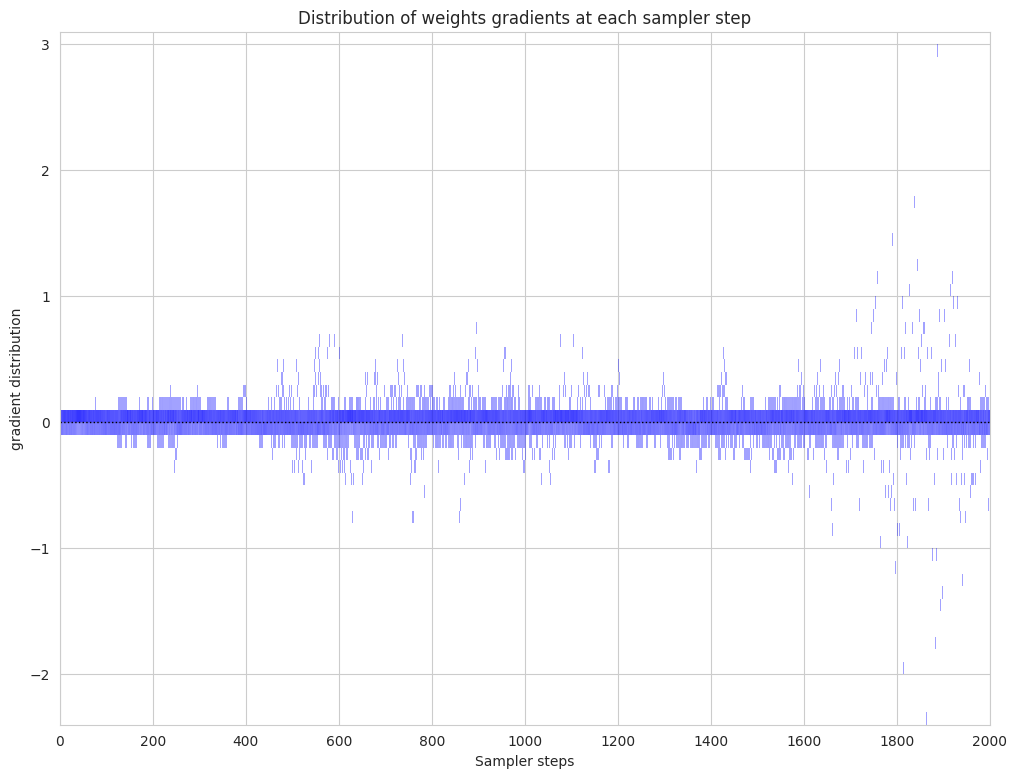

In [19]:
grad_dist.plot("weights")

### OnlineLossStatistics, OnlineTraceStatistics

In [20]:
from devinterp.slt.callback import validate_callbacks
from devinterp.slt.loss import OnlineLossStatistics
from devinterp.slt.norms import GradientNorm, NoiseNorm, WeightNorm
from devinterp.slt.trace import OnlineTraceStatistics

# llc estimator for OnlineLossStatistics
llc_estimator = OnlineLLCEstimator(
    num_chains=NUM_CHAINS,
    num_draws=NUM_DRAWS,
    nbeta=len(train_data),
    init_loss=get_init_loss_multi_batch(
        dataloader=train_loader,
        model=model,
        device=DEVICE,
        n_batches=16,
        evaluate=evaluate_mse,
    ),
)
loss_statistics = OnlineLossStatistics(base_callback=llc_estimator)

# weight norm for OnlineTraceStatistics
weight_norm = weight_norm = WeightNorm(
    num_chains=NUM_CHAINS, num_draws=NUM_DRAWS, device=DEVICE
)
trace_statistics = OnlineTraceStatistics(
    base_callback=weight_norm, attribute="weight_norms"
)

In [21]:
# validate_callbacks throws an error if you try to pass a derivative callback before its base callback
callbacks = [loss_statistics, llc_estimator]
validate_callbacks(callbacks)

ValueError: Derivative callback <devinterp.slt.loss.OnlineLossStatistics object at 0x7f91a75c8e50> must be called after base callback <devinterp.slt.llc.OnlineLLCEstimator object at 0x7f91a75d6040>.

In [22]:
# it passes True if the callbacks meet the ordering condition
callbacks = [llc_estimator, loss_statistics, weight_norm, trace_statistics]
validate_callbacks(callbacks)

True

In [23]:
results = run_callbacks(train_loader, train_data, model=model, callbacks=callbacks)

If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.


Chain 19: 100%|██████████| 2000/2000 [00:03<00:00, 535.85it/s]


**OnlineTraceStatistics**

`OnlineTraceStatistics` is a general purpose 'derivative' `SamplerCallback` that takes any base statistic that's computed as a trace and computes the mean and standard deviation of that statistic in two ways: across *draws* and across *chains*.

The black dotted lines and gray overlays in the previous charts are a visualization of what it looks like to compute the mean and std across *draws*.

The mean and std statistics computed across a *chain* are the cumulative mean and std of that single chain at a given draw step. For example, the final mean and std computed for a chain would be the mean and std of the base statistic computed at all draw steps of that chain.

In [24]:
# Mean and std for each chain of the computed weight norms
means = results["weight_norms/chain/mean"]
stds = results["weight_norms/chain/std"]

print("The shapes match the shape of the trace.")
print(means.shape)
print(stds.shape)

print("\nThe mean of all draw steps across a given chain i is the ith index below.")
final_means = means[:, -1]
print(final_means)

print("\nThe std of all draw steps across chain 5:")
std = stds[5, -1]
print(std)

The shapes match the shape of the trace.
(20, 2000)
(20, 2000)

The mean of all draw steps across a given chain i is the ith index below.
[0.50411123 0.32196382 0.59018016 0.3667175  0.4143017  0.37731305
 0.47246945 0.36382496 0.6432762  0.58859307 0.28380862 0.41569713
 0.33385512 0.4882355  0.39871842 0.49782977 0.37063482 0.43182674
 0.32041517 0.4569179 ]

The std of all draw steps across chain 5:
0.17924201


**OnlineLossStatistics**

Since we're using minibatches instead of being in the limit of infinite training data, there's noise introduced by the random selection of minibatch. We can estimate/visualize the noise by looking at a histogram of the initial losses of each chain in our sampler, since these are losses from different minibatches on a fixed weight. Note that we get this by calling a method of `OnlineLossStatistics` rather than referring to `results`.

Note that these values may be so close together that it causes a rendering issue in `plt.hist`, but we can see from the values that the minibatch noise is very small.

tensor([0.0635, 0.0635, 0.0635, 0.0635, 0.0635, 0.0635, 0.0635, 0.0635, 0.0635,
        0.0635, 0.0635, 0.0635, 0.0635, 0.0635, 0.0635, 0.0635, 0.0635, 0.0635,
        0.0635, 0.0635])

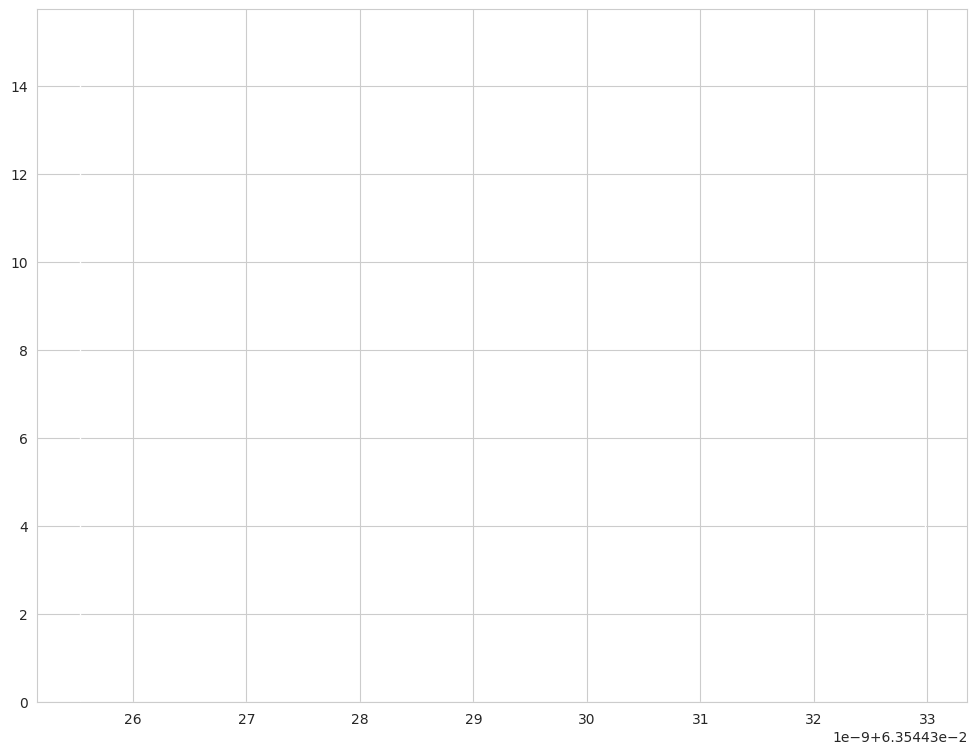

In [25]:
init_losses = loss_statistics.loss_hist_by_draw(draw=0, bins=10)
init_losses

`OnlineLossStatistics` also provides a few ways to check the "health" of your loss chains. For example, your chains should ideally not be achieving loss values lower than your initial loss. You can see the loss values directly by plotting the loss trace, or you can check the cumulative percent of negative steps relative to the initial loss through a few statistics computed by `OnlineLossStatistics`, one of which is `"loss/percent_neg_steps"`.

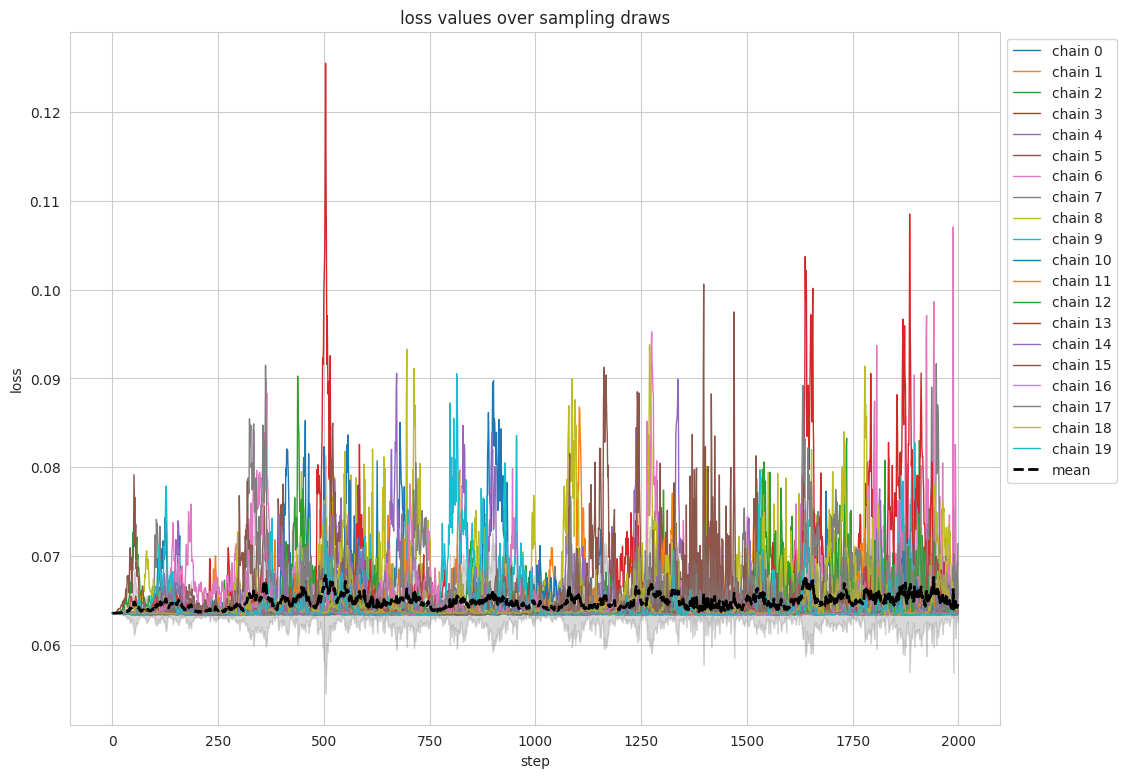

<Figure size 1200x900 with 0 Axes>

In [26]:
loss_trace = results["loss/trace"]
plot_trace(loss_trace, "loss")

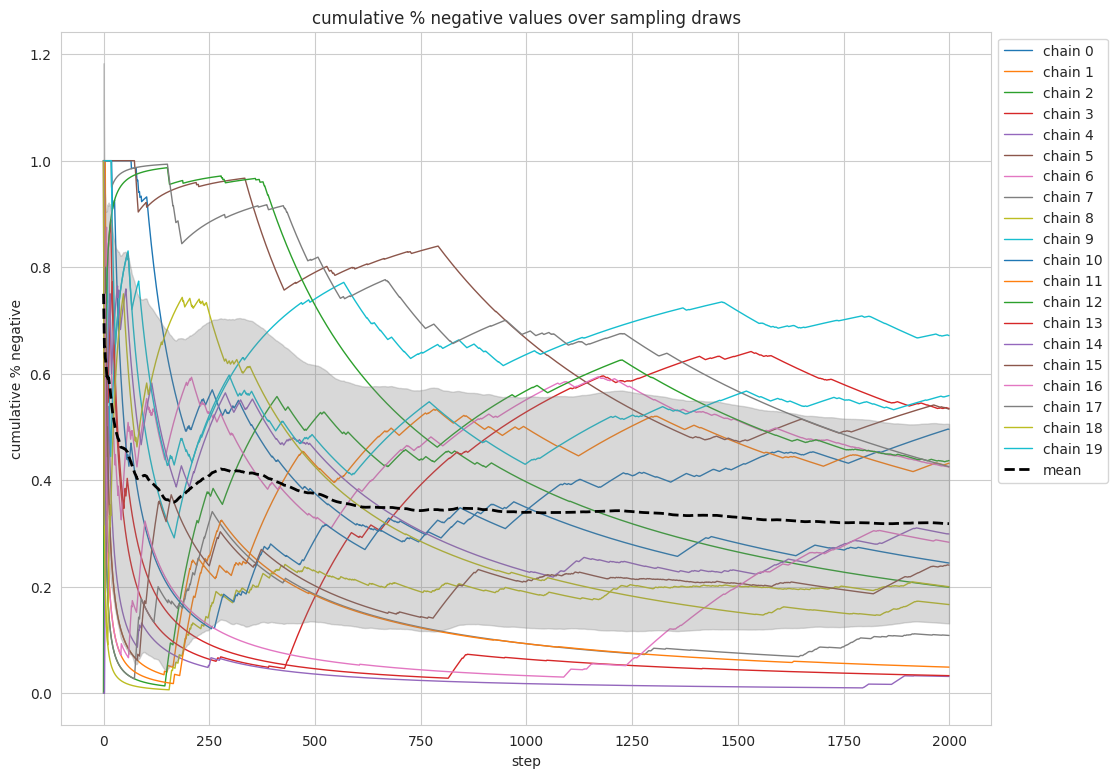

<Figure size 1200x900 with 0 Axes>

In [27]:
cum_perc_neg_steps = results["loss/percent_neg_steps"]
plot_trace(cum_perc_neg_steps, "cumulative % negative")

Recall that there is still some minibatch noise, so we can also check how negative losses are relative to the initial loss while also thresholding by the estimated minibatch noise. Most negative draws end up within the threshold, and any chains that still end up consistently negative can be pruned from estimations.

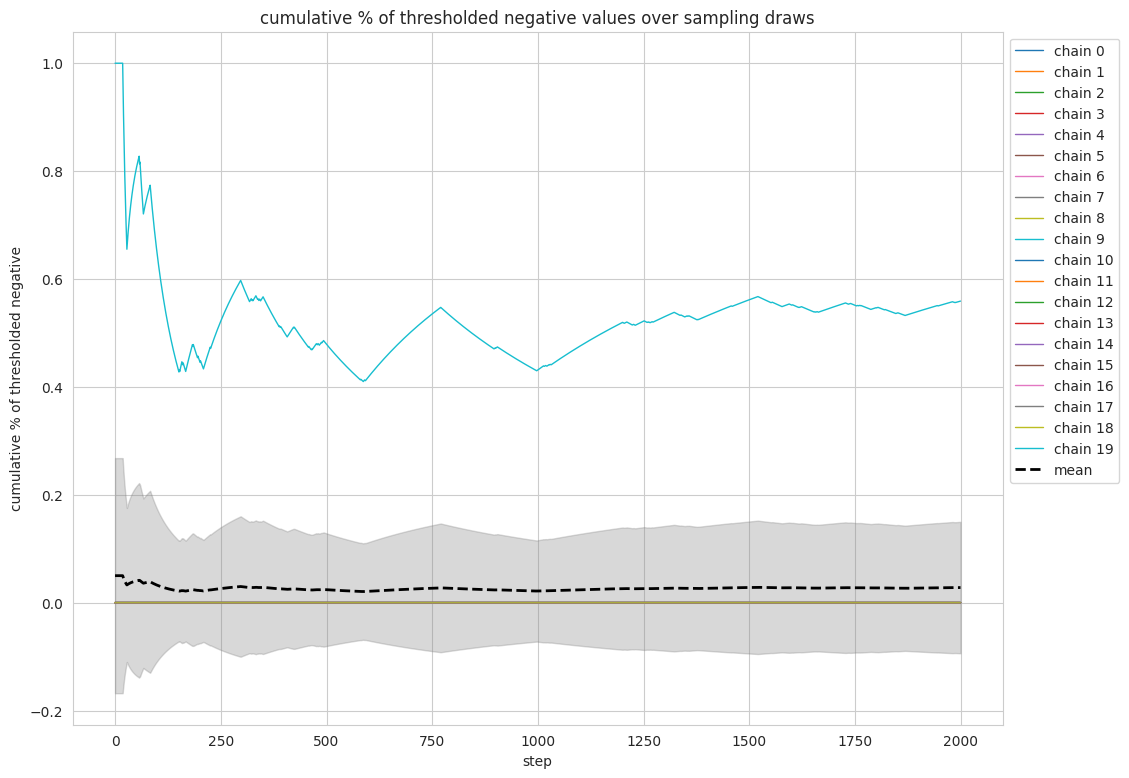

<Figure size 1200x900 with 0 Axes>

In [28]:
thresholded_neg_steps = results["loss/percent_thresholded_neg_steps"]
plot_trace(thresholded_neg_steps, "cumulative % of thresholded negative")